In [206]:
%matplotlib inline
import os
import sys
from scipy import optimize
from scipy.optimize import leastsq
from numpy import *
import glob
from matplotlib import *
from pylab import *

import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
# mpl.rcParams['font.family'] = 'Times'
# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'Times'
# mpl.rcParams['mathtext.it'] = 'Times:italic'
# mpl.rcParams['mathtext.bf'] = 'Times'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.formatter.limits'] = [-5,5]

In [207]:
def get_file_detuning_1(file):
    underscore_locations = [index for index, character in enumerate(file)
                            if character == "_"]
    left = underscore_locations[9] + 1
    right = underscore_locations[10]
    detuning = file[left:right]
    detuning = int(float(detuning))
    return detuning

def get_file_detuning_2(file):
    underscore_locations = [index for index, character in enumerate(file)
                            if character == "_"]
    left = underscore_locations[10] + 1
    right = underscore_locations[11]
    detuning = file[left:right]
    detuning = int(float(detuning))
    return detuning

def get_files_1(data_set, power_folder):
    parent_folder = os.path.dirname(os.path.dirname(sys.path[0]))
    path = os.path.join(parent_folder, data_set, power_folder, "Spectrum")
    print(data_set, power_folder, path)
    os.chdir(path)
    files= glob.glob('*.txt')
    return files

def get_files_2(data_set, power_folder):
    parent_folder = os.path.dirname(os.path.dirname(sys.path[0]))
    power_folder_path = os.path.join(parent_folder, data_set, "Spectrum", power_folder)
    files = []
    for folder in os.listdir(power_folder_path):
        path = os.path.join(power_folder_path, folder)
        for file in os.listdir(path):
            files.append(os.path.join(power_folder_path, folder, file))
    return files

def get_detuning_files_dict_1(data_set, power_folder):
    files = get_files_1(data_set, power_folder)
    detunings = sorted(list(set([get_file_detuning_1(file) for file in files])), reverse=True)
    detuning_files_dict = {detuning: [] for detuning in detunings}
    for file in files:
        detuning_files_dict[get_file_detuning_1(file)].append(file)
    return detuning_files_dict, detunings

def get_detuning_files_dict_2(data_set, power_folder):
    files = get_files_2(data_set, power_folder)
    detunings = sorted(list(set([get_file_detuning_2(file) for file in files])), reverse=True)
    detuning_files_dict = {detuning: [] for detuning in detunings}
    for file in files:
        detuning_files_dict[get_file_detuning_2(file)].append(file)
    return detuning_files_dict, detunings

def get_file_contents(file):
    with open(file,'r') as f:
        file_contents=f.readlines()
    return file_contents

In [208]:
def convert_to_mW(input_list):
    converted_list = (10**(input_list/10))/1000
    return converted_list

In [209]:
def get_voltage(data):
    voltage = [float(line.strip().split('\t')[0]) for line in data[1:]]
    voltage = array(voltage)
    return voltage

def get_frequency(detuning, detuning_files_dict):
    file = detuning_files_dict[detuning][0]
    raw_data = get_file_contents(file)
    frequency = [float(line.strip().split('\t')[1]) for line in raw_data[1:]]
    frequency = array(frequency)
    return frequency

def get_S21_detuning(voltage, power):
    power_mW = convert_to_mW(power)
    S21 = voltage/power_mW
    return S21

def get_S21_normalised(S21_list, index_maxima):
    S21_normalised = [S21/S21[index] for S21, index in zip(S21_list, index_maxima)]
    return S21_normalised

In [210]:
def get_voltage_from_file(file, power):
    raw_data = get_file_contents(file)
    voltage = get_voltage(raw_data)
    voltage = convert_to_mW(voltage)
    S21_detuning = get_S21_detuning(voltage, power)
    index_maximum = get_index_maximum(voltage)
    return S21_detuning, index_maximum

def get_gamma(detuning, detuning_files_dict, power):
    file_results = [get_voltage_from_file(file, power) for file in detuning_files_dict[detuning]]
    S21_list_detuning, index_maxima = zip(*file_results)
    frequency = get_frequency(detuning, detuning_files_dict)
    frequency = get_offset_frequency(frequency, index_maxima)
    S21_offset_list = get_S21_offset_list(S21_list_detuning, index_maxima)
    S21_average = average(S21_offset_list, axis=0)
    p_final = fit(S21_average, frequency)
    gamma = p_final[1]
    title = f"Detuning: {detuning}, Power: {power}"
    create_figure_1(S21_average, frequency, title=title)
    return gamma

In [211]:
def get_index_maximum(voltage):
    voltage = get_moving_average(voltage, 6)
    max_index = argmax(array(voltage))
    return max_index

def get_moving_average(points, window_width):
    N = len(points)
    window_points = [[points[inside_window(i+j, N)] for i in range(window_width)]
                     for j in range(N)]
    moving_average = array([sum(window)/window_width for window in window_points])
    return moving_average

def inside_window(i, N):
    if i < 0:
        return 0
    elif i > N-1:
        return N-1
    return i

In [212]:
def get_offset_frequency(frequency, index_maxima):
    min_index, max_index = min(index_maxima), max(index_maxima)
    frequency = frequency[0:len(frequency) - (max_index - min_index)]
    resonant_frequency = frequency[min_index]
    frequency -= resonant_frequency
    return frequency

def get_S21_offset_list(S21_list, index_maxima):
    min_index, max_index = min(index_maxima), max(index_maxima)
    S21_offset_list = [get_S21_offset(S21, index, min_index, max_index)
                       for S21, index in zip(S21_list, index_maxima)]
    return S21_offset_list

def get_S21_offset(S21, index, min_index, max_index):
    left_index = index - min_index
    right_index = len(S21) - (max_index - index)
    S21_offset = S21[left_index:right_index]
    return S21_offset

In [213]:
def create_figure_1(S21_list, frequency, filter_rate=1, title="S21 vs frequency"):
    S21_list = ensure_2D_list(S21_list)
    for index, S21 in enumerate(S21_list):
        if index % filter_rate == 0:
            plot_figure_1(frequency, S21)
    add_plot_labels(title)
    plt.show()
    input()
    plt.close('all')

def ensure_2D_list(test_list):
    if hasattr(test_list[0], '__iter__'):
        return test_list
    else:
        return [test_list]

def add_plot_labels(title):
    plt.title(title)
    #plt.xlim(-2*10**7, 3.5*10**7)
    x_ticks = plt.xticks()[0]
    x_labels = [f'{value:.0f}' for value in plt.xticks()[0]/10**3]
    plt.xticks(x_ticks, x_labels)

def plot_figure_1(frequency, voltage):
    plt.plot(frequency, voltage,'.',alpha=1)
    plt.xlabel('${\omega_c}$ (kHz)')
    plt.ylabel('Amplitude')

In [214]:
def peval(freq,p):
    F = p[0]
    gamma = p[1]
    noise = p[2]
    w = p[3]
    res = (F/(gamma**2+4*(freq-w)**2))+noise
    return res

def residuals(p,X,f):
    res=peval(f,p)-X
    return res

def fit(S21, freq):
    p0=[10e-10, 20, 0.6e-14, 0]
    #p0=[7e-10, 3.53181220e+01, 5.69756968e-14, 4.02844320e+09]
    # The second parameter in p_final is Gamma_m
    plsq=leastsq(residuals,p0,args=(S21,freq),full_output=1)
    p_final=plsq[0]
    return p_final

In [215]:
def output_gamma(detunings, gamma_list, data_set, power_folder):
    output_path = prepare_output_path()
    file_name = os.path.join(output_path, f"gamma_vs_detuning_{data_set}_{power_folder}")
    with open(file_name, "w+") as file:
        file.writelines("Detuning\tGamma\n")
        for detuning, gamma, in zip(detunings, gamma_list):
            file.writelines(f"{detuning}\t{gamma}\n")

def prepare_output_path():
    parent_path = os.path.dirname(sys.path[0])
    output_path = os.path.join(parent_path, "Gamma Results")
    if os.path.isdir(output_path) is False:
        os.mkdir(output_path)
    return output_path

In [216]:
def process_experiment_1(data_set, power_folder):
    detuning_files_dict, detunings = get_detuning_files_dict_1(data_set, power_folder)
    power = int(power_folder[0:2])
    gamma_list = [get_gamma(detuning, detuning_files_dict, power) for detuning in detunings]
    output_gamma(detunings, gamma_list, data_set, power_folder)

def process_experiment_2(data_set, power_folder):
    detuning_files_dict, detunings = get_detuning_files_dict_2(data_set, power_folder)
    power = int(power_folder[0:2])
    gamma_list = [get_gamma(detuning, detuning_files_dict, power) for detuning in detunings]
    output_gamma(detunings, gamma_list, data_set, power_folder)

def iterate_through_power_levels_1(data_set):
    path = os.path.join(os.path.dirname(os.path.dirname(sys.path[0])), data_set)
    for power_folder in os.listdir(path)[0:1]:
        process_experiment_1(data_set, power_folder)

def iterate_through_power_levels_2(data_set):
    path = os.path.join(os.path.dirname(os.path.dirname(sys.path[0])), data_set, "Spectrum")
    for power_folder in os.listdir(path):
        process_experiment_1(data_set, power_folder)


15112022 26_dBm /home/henry/Documents/Physics Internship/15112022/26_dBm/Spectrum


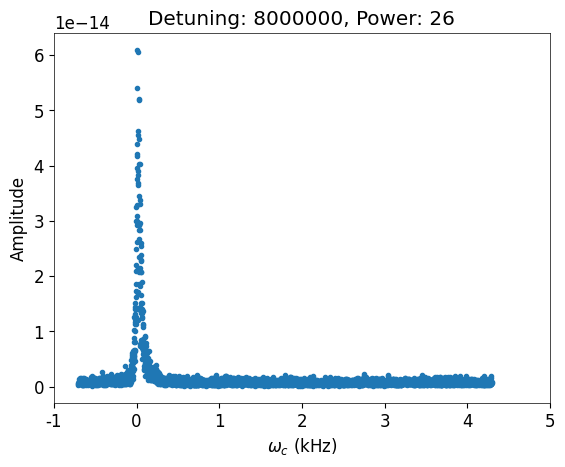

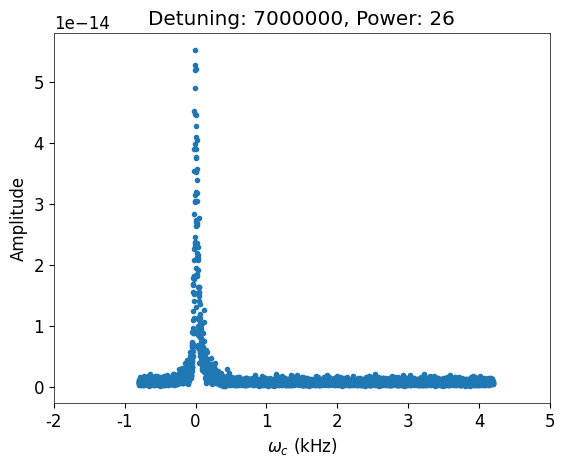

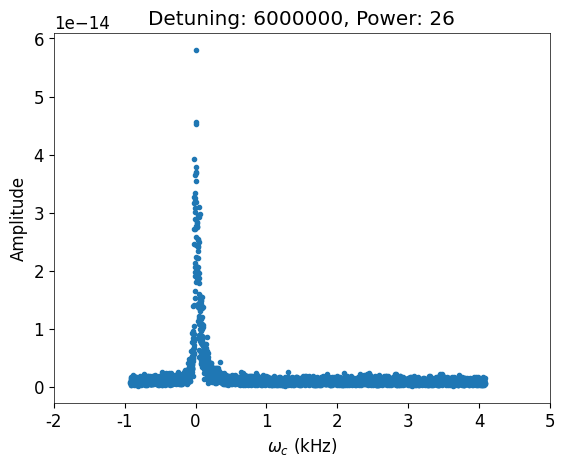

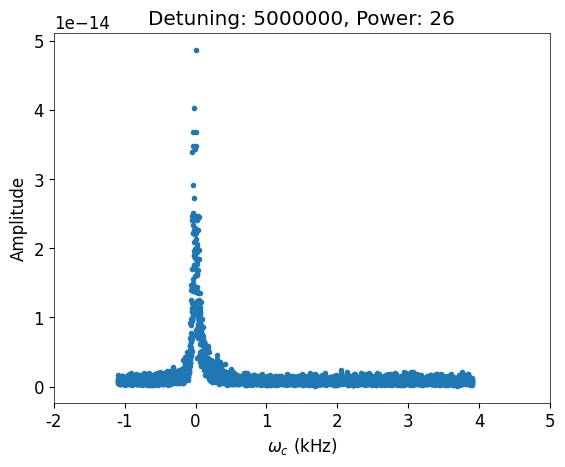

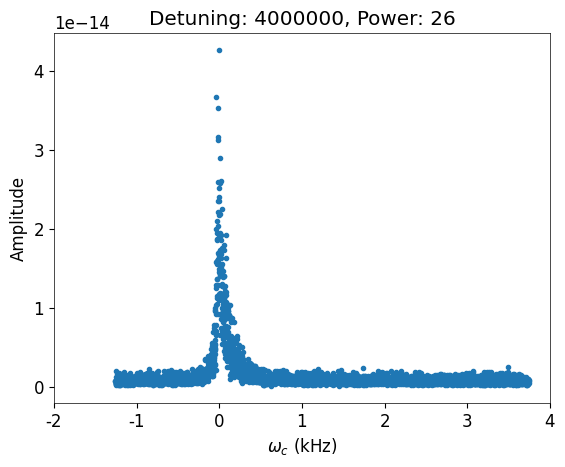

KeyboardInterrupt: Interrupted by user

In [217]:
"""
For data sets in the same format as 15112022, use version 1 of functions
For data sets in the same format as 16112022, use version 2 of functions
You should only ever need to change the number on iterate_through_power_levels_i
"""
data_set = "15112022"
iterate_through_power_levels_1(data_set)